In [1]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test


def remove_nan_examples(data):
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

In [3]:
data_original = pd.read_csv('./AAPL1216.csv')[::-1]

## Conv기반 windowing ->
openp = data_original['Open'].tolist()
highp = data_original['High'].tolist()
lowp = data_original['Low'].tolist()
closep = data_original['Adj Close'].tolist()
volumep = data_original['Volume'].tolist()

In [4]:
WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 1

In [5]:
X, Y = [], []
#normalize every dimension of time window independently
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        #다음날의 주가의 오름 혹은 내림을 예측하고 싶기 때문에 단일 디멘젼에서의 변화를 classify 
        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

In [6]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [7]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

# Conv1D
model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(2)) # up/down
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

C:\Users\yckim\Anaconda3\envs\TS_sample2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(30, 5), filters=16, kernel_size=4, padding="same")`
  """
C:\Users\yckim\Anaconda3\envs\TS_sample2\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, padding="same")`
  del sys.path[0]


In [8]:
# LR스케쥴러
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
# save model
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(X_test))

C:\Users\yckim\Anaconda3\envs\TS_sample2\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 877 samples, validate on 98 samples
Epoch 1/100
877/877 [==============================] - 1s 1ms/step - loss: 0.8143 - accuracy: 0.5120 - val_loss: 0.7066 - val_accuracy: 0.4592

Epoch 00001: val_loss improved from inf to 0.70659, saving model to lolkek.hdf5
Epoch 2/100
877/877 [==============================] - 0s 82us/step - loss: 0.7542 - accuracy: 0.5325 - val_loss: 0.7142 - val_accuracy: 0.4490

Epoch 00002: val_loss did not improve from 0.70659
Epoch 3/100
128/877 [===>..........................] - ETA: 0s - loss: 0.8168 - accuracy: 0.4922

C:\Users\yckim\Anaconda3\envs\TS_sample2\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


877/877 [==============================] - 0s 83us/step - loss: 0.7327 - accuracy: 0.5439 - val_loss: 0.7159 - val_accuracy: 0.4694

Epoch 00003: val_loss did not improve from 0.70659
Epoch 4/100
877/877 [==============================] - 0s 80us/step - loss: 0.7296 - accuracy: 0.5393 - val_loss: 0.7137 - val_accuracy: 0.4898

Epoch 00004: val_loss did not improve from 0.70659
Epoch 5/100
877/877 [==============================] - 0s 92us/step - loss: 0.6994 - accuracy: 0.5644 - val_loss: 0.7109 - val_accuracy: 0.4490

Epoch 00005: val_loss did not improve from 0.70659
Epoch 6/100
877/877 [==============================] - 0s 96us/step - loss: 0.6981 - accuracy: 0.5564 - val_loss: 0.7093 - val_accuracy: 0.4490

Epoch 00006: val_loss did not improve from 0.70659
Epoch 7/100
877/877 [==============================] - 0s 94us/step - loss: 0.6921 - accuracy: 0.5701 - val_loss: 0.7131 - val_accuracy: 0.4694

Epoch 00007: val_loss did not improve from 0.70659
Epoch 8/100
877/877 [===========

877/877 [==============================] - 0s 99us/step - loss: 0.6420 - accuracy: 0.6260 - val_loss: 0.6926 - val_accuracy: 0.5408

Epoch 00043: val_loss did not improve from 0.68100
Epoch 44/100
877/877 [==============================] - 0s 95us/step - loss: 0.6436 - accuracy: 0.6283 - val_loss: 0.6955 - val_accuracy: 0.5102

Epoch 00044: val_loss did not improve from 0.68100
Epoch 45/100
877/877 [==============================] - 0s 117us/step - loss: 0.6279 - accuracy: 0.6408 - val_loss: 0.6909 - val_accuracy: 0.5408

Epoch 00045: val_loss did not improve from 0.68100
Epoch 46/100
877/877 [==============================] - 0s 100us/step - loss: 0.6451 - accuracy: 0.6260 - val_loss: 0.6872 - val_accuracy: 0.5102

Epoch 00046: val_loss did not improve from 0.68100
Epoch 47/100
877/877 [==============================] - 0s 97us/step - loss: 0.6360 - accuracy: 0.6363 - val_loss: 0.6913 - val_accuracy: 0.5612

Epoch 00047: val_loss did not improve from 0.68100
Epoch 48/100
877/877 [====

877/877 [==============================] - 0s 99us/step - loss: 0.6028 - accuracy: 0.6727 - val_loss: 0.6790 - val_accuracy: 0.5918

Epoch 00084: val_loss did not improve from 0.66615
Epoch 85/100
877/877 [==============================] - 0s 100us/step - loss: 0.5962 - accuracy: 0.6762 - val_loss: 0.6956 - val_accuracy: 0.5918

Epoch 00085: val_loss did not improve from 0.66615
Epoch 86/100
877/877 [==============================] - 0s 103us/step - loss: 0.6033 - accuracy: 0.6830 - val_loss: 0.6961 - val_accuracy: 0.5612

Epoch 00086: val_loss did not improve from 0.66615
Epoch 87/100
877/877 [==============================] - 0s 106us/step - loss: 0.5981 - accuracy: 0.6659 - val_loss: 0.6936 - val_accuracy: 0.5714

Epoch 00087: val_loss did not improve from 0.66615
Epoch 88/100
877/877 [==============================] - 0s 100us/step - loss: 0.5886 - accuracy: 0.6910 - val_loss: 0.6806 - val_accuracy: 0.5714

Epoch 00088: val_loss did not improve from 0.66615
Epoch 89/100
877/877 [==

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(C / C.astype(np.float).sum(axis=1))

[[0.71428571 0.28571429]
 [0.46938776 0.53061224]]


which shows that we predict “UP” movement with 70% of accuracy and “DOWN” with 51% of accuracy

In [11]:
for i in range(len(pred)):
     print(Y_test[i], pred[i])

[1 0] [0.6338408 0.3661592]
[1 0] [0.7959021  0.20409791]
[1 0] [0.666735   0.33326498]
[1 0] [0.5082663  0.49173376]
[0 1] [0.53186685 0.46813312]
[0 1] [0.6448086  0.35519144]
[0 1] [0.5580725  0.44192743]
[0 1] [0.56525654 0.43474352]
[0 1] [0.5619171  0.43808287]
[1 0] [0.574535  0.4254649]
[1 0] [0.67273515 0.3272648 ]
[1 0] [0.53330415 0.4666958 ]
[0 1] [0.31873715 0.68126285]
[0 1] [0.33054277 0.6694572 ]
[0 1] [0.52954394 0.4704561 ]
[1 0] [0.6253914  0.37460855]
[0 1] [0.62574345 0.37425652]
[1 0] [0.5611033  0.43889672]
[1 0] [0.6614097  0.33859032]
[1 0] [0.6438691 0.3561309]
[1 0] [0.6675757  0.33242428]
[1 0] [0.5431795 0.4568205]
[1 0] [0.22493379 0.7750662 ]
[1 0] [0.41223347 0.58776647]
[0 1] [0.5818549  0.41814503]
[0 1] [0.2874361 0.712564 ]
[1 0] [0.18792698 0.81207305]
[0 1] [0.3240721 0.6759279]
[0 1] [0.74137646 0.2586235 ]
[1 0] [0.69114697 0.30885312]
[1 0] [0.3727069  0.62729317]
[0 1] [0.31318018 0.68681985]
[0 1] [0.33845702 0.661543  ]
[0 1] [0.22130182 0.77

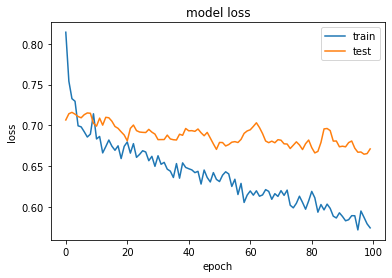

In [12]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()